In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# weird behaviour from this example
mouse = 25
day = 25

In [3]:
session_type = 'OF1'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/COHORT12_nolfp')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)



In [4]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
list(tuning_scores)

['hd_mean_vector_length',
 'grid_score',
 'theta_index',
 'speed_correlation',
 'ellipse_grid_score',
 'spatial_information']

In [5]:
cluster_ids_ordered = np.array(tuning_scores['grid_score'].sort_values(by='grid_score', ascending=False, na_position='last')['cluster_id'])

bin_config = get_bin_config(session_type)[('P_x', 'P_y')]

tcs = {}
for index in cluster_ids_ordered:
    neuron = neurons[neurons.index == index]
    tc = nap.compute_2d_tuning_curves(
        neuron,
        np.stack([session['P_x'], session['P_y']], axis=1),
        nb_bins=bin_config['num_bins'],
        minmax=bin_config['bounds'],
        ep=session['moving']
        )[0][index]
    tc = gaussian_filter_nan(
        tc,
        sigma=(bin_config['smooth_sigma'], bin_config['smooth_sigma']),
        )
    tcs[index] = tc
    

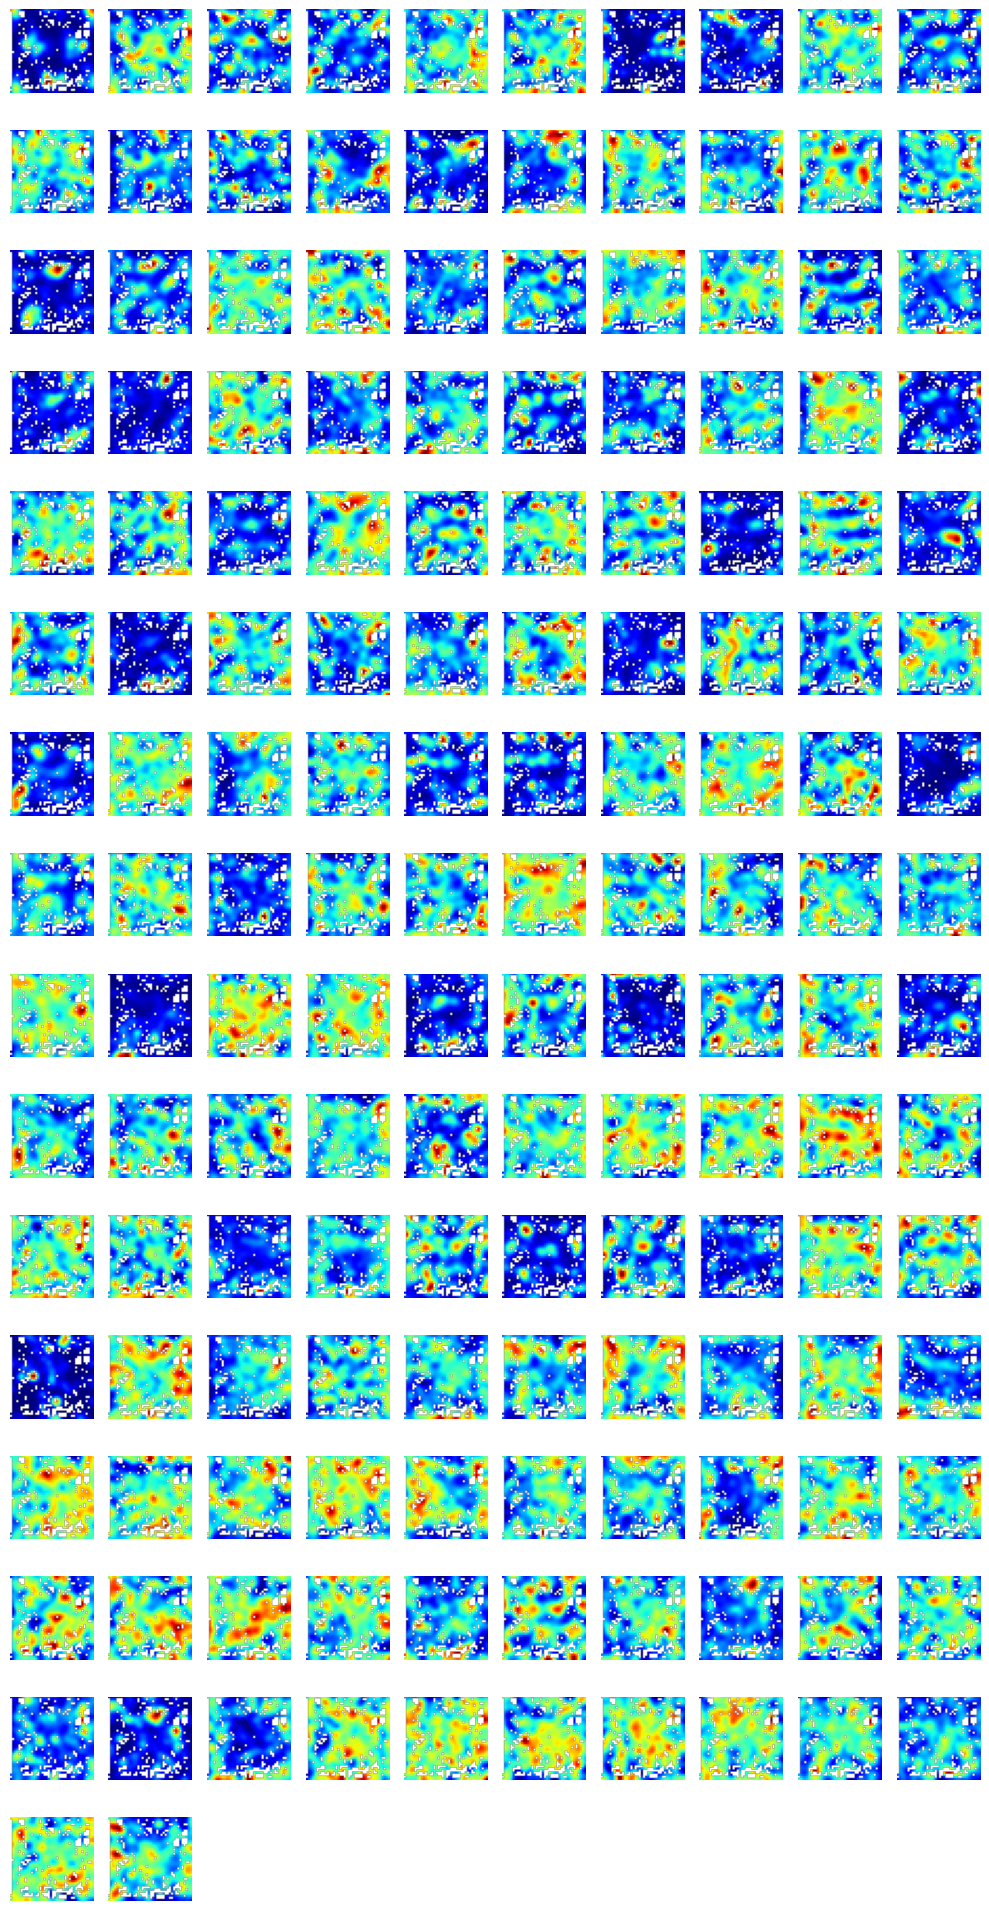

In [6]:
# Plot
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = cluster_ids_ordered[counter]
            ax[j, i].imshow(tcs[index], cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()